# Models with data without dimensional reduction 
- Models includes KNN, lasso, ridge, decision tree, gradient boosting, adaboost, bagging, svm, and xgboost.
- We use 5-fold cross validation to ensure model robustness and avoid overfitting.

Evaluation metrics:
  
+ MSE
+ RMSE
+ MAE
+ MAPE

Steps:

1. 5-fold on training set
2. Find the best hyper parameters
3. 5-fold as the final training set, re-train with the best hyper parameters
4. Save model
5. Measure the performance on the test set

## Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV ,cross_validate

## Define function

In [2]:
def evaluate(y_true, y_pred):
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))

## Read Dataset

In [42]:
data_train = pd.read_csv('processed_training.csv')
data_test = pd.read_csv('processed_test.csv')
data_train.head()

,attendance,is_federal_holiday,venue,on_grass,temperature,wind_speed,team1_name,team1_pre_win,team1_pre_loss,team1_pre_win_pct,...,season_type,season,home_team_avg_att_last_year,start_hour,start_hour_label_afternoon,start_hour_label_evening,start_hour_label_night,start_hour_label_noon,game_page_url,start_time
0,35055,0,Wrigley Field,1,-2.786672,-0.093090,STL,-1.62645,-1.654514,0.0,...,regular,2015,0.345307,19,0,1,0,0,https://www.baseball-reference.com/boxes/CHN/C...,2015-04-05 19:17:00
1,49043,0,Chase Field,1,0.705205,-0.093090,SFG,-1.62645,-1.654514,0.0,...,regular,2015,-0.573314,19,0,1,0,0,https://www.baseball-reference.com/boxes/ARI/A...,2015-04-06 19:13:00
2,43633,0,Great American Ball Park,1,-0.521670,1.490839,PIT,-1.62645,-1.654514,0.0,...,regular,2015,0.066649,16,1,0,0,0,https://www.baseball-reference.com/boxes/CIN/C...,2015-04-06 16:10:00
3,45030,0,Comerica Park,1,-2.031671,-0.489072,MIN,-1.62645,-1.654514,0.0,...,regular,2015,0.766348,13,0,0,0,1,https://www.baseball-reference.com/boxes/DET/D...,2015-04-06 13:08:00
4,43753,0,Minute Maid Park,1,0.516455,1.292848,CLE,-1.62645,-1.654514,0.0,...,regular,2015,-1.084575,18,0,1,0,0,https://www.baseball-reference.com/boxes/HOU/H...,2015-04-06 18:10:00


## Data processing

In [43]:
data_train.drop(['venue', 'start_hour', 'wind_speed', 'game_page_url', 'start_time'], axis=1, inplace=True)
data_test.drop(['venue', 'start_hour', 'wind_speed', 'game_page_url', 'start_time'], axis=1, inplace=True)

In [44]:
data_train = pd.get_dummies(data_train, columns=['team1_name', 'team2_name', 'season_type'])
data_test = pd.get_dummies(data_test, columns=['team1_name', 'team2_name', 'season_type'])

In [45]:
print(list(data_train.columns))

['attendance', 'is_federal_holiday', 'on_grass', 'temperature', 'team1_pre_win', 'team1_pre_loss', 'team1_pre_win_pct', 'team1_streak', 'team2_pre_win', 'team2_pre_loss', 'team2_pre_win_pct', 'team2_streak', 'Adam-Jones', 'Chris-Sale', 'Aroldis-Chapman', 'Miguel-Cabrera', 'David-Price', 'Giancarlo-Stanton', 'Wade-Davis', 'Alex-Gordon', 'Albert-Pujols', 'Mike-Trout', 'Adrian-Gonzalez', 'Zack-Greinke', 'Clayton-Kershaw', 'Ryan-Braun', 'Brett-Gardner', 'Mark-Teixeira', 'A.J.-Burnett', 'Andrew-McCutchen', 'Mark-Melancon', 'Justin-Upton', 'Madison-Bumgarner', 'Buster-Posey', 'Nelson-Cruz', 'Felix-Hernandez', 'Matt-Holliday', 'Yadier-Molina', 'Jhonny-Peralta', 'Prince-Fielder', 'Jose-Bautista', 'Russell-Martin', 'Max-Scherzer', 'Paul-Goldschmidt', 'Zack-Britton', 'Mark-Trumbo', 'Matt-Wieters', 'Craig-Kimbrel', 'David-Ortiz-HOF', 'Jake-Arrieta', 'Dexter-Fowler', 'Jon-Lester', 'Ben-Zobrist', 'Jose-Quintana', 'Carlos-Gonzalez', 'Eric-Hosmer', 'Kenley-Jansen', 'Yoenis-Céspedes', 'Bartolo-Colon',

In [46]:
train_cols = data_train.columns.tolist()
data_test = data_test[train_cols].copy()

In [47]:
print(set(data_train.columns) - set(data_test.columns))
print(set(data_test.columns) - set(data_train.columns))

set()
set()


In [48]:
data_train = shuffle(data_train)

In [49]:
y_train = data_train['attendance'].to_numpy()
y_test = data_test['attendance'].to_numpy()

data_train.drop(['attendance'], axis=1, inplace=True)
data_test.drop(['attendance'], axis=1, inplace=True)

x_train = data_train.to_numpy()
x_test = data_test.to_numpy()

print(x_train.shape)

(12270, 272)


## KNN
### Cross validation

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
parameters = {'n_neighbors': [3, 5, 10, 20, 30, 50, 100], 'p': [1, 2],
 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
model = KNeighborsRegressor(n_jobs=-1)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 10, 20, 30, 50, 100],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: KNeighborsRegressor(n_jobs=-1, p=1, weights='distance')
Best parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_p,param_weights,params,split0_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,0.036198,0.002786,8.969412,0.511707,auto,3,1,uniform,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 1...",-3.198338e+07,...,82.828566,9,-0.163238,-0.163793,-0.156657,-0.157887,-0.169582,-0.162232,0.004635,9
1,0.041615,0.010172,9.214550,0.899181,auto,3,1,distance,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 1...",-3.027757e+07,...,83.594107,1,-0.157106,-0.156979,-0.150450,-0.152231,-0.162908,-0.155935,0.004356,1
2,0.038991,0.002593,0.737424,0.098235,auto,3,2,uniform,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 2...",-3.387858e+07,...,91.303532,21,-0.171562,-0.169354,-0.162304,-0.163784,-0.177062,-0.168813,0.005358,17
3,0.047268,0.005237,0.848741,0.073533,auto,3,2,distance,"{'algorithm': 'auto', 'n_neighbors': 3, 'p': 2...",-3.275833e+07,...,87.971539,15,-0.167665,-0.165623,-0.159062,-0.160823,-0.173394,-0.165314,0.005102,15
4,0.048969,0.012149,9.654542,0.862578,auto,5,1,uniform,"{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1...",-3.180218e+07,...,71.549185,29,-0.169857,-0.171104,-0.165079,-0.164769,-0.178426,-0.169847,0.004974,25


### Training with best parameters

In [22]:
knn = KNeighborsRegressor(algorithm='auto', n_neighbors=5, p=1, weights='distance', n_jobs=-1)
knn = knn.fit(x_train, y_train)

In [23]:
train_predict = knn.predict(x_train)
evaluate(y_train, train_predict)

MSE: 0.0
RMSE: 0.0
MAE: 0.0
MAPE: 0.0


### Evaluate testing set

In [24]:
y_pred = knn.predict(x_test)
evaluate(y_test, y_pred)

MSE: 61096566.40299257
RMSE: 7816.429261689289
MAE: 6090.924326831434
MAPE: 0.28480501695029914


## Lasso

### cross validation to find best parameters

In [ ]:
# use grid search to find the best alpha
alphas = np.logspace(-3, 3, 20)
print(alphas)

[1.00000000e-03 2.06913808e-03 4.28133240e-03 8.85866790e-03
 1.83298071e-02 3.79269019e-02 7.84759970e-02 1.62377674e-01
 3.35981829e-01 6.95192796e-01 1.43844989e+00 2.97635144e+00
 6.15848211e+00 1.27427499e+01 2.63665090e+01 5.45559478e+01
 1.12883789e+02 2.33572147e+02 4.83293024e+02 1.00000000e+03]


In [ ]:
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=5, scoring='neg_root_mean_squared_error')
grid.fit(x_train, y_train)

print("best alpha: ", grid.best_estimator_.alpha)

c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+11, tolerance: 1.070e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+11, tolerance: 1.066e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\Anaconda3\envs\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

best alpha:  1.438449888287663


### Train with best parameters

In [ ]:
best_alpha = grid.best_estimator_.alpha

Lasso(alpha=1.438449888287663)

In [25]:
# train the model with the best alpha
best_model = Lasso(alpha=1.438449888287663)
best_model.fit(x_train, y_train)

Lasso(alpha=1.438449888287663)

In [26]:
train_predict = best_model.predict(x_train)
evaluate(y_train, train_predict)

MSE: 26515320.423543107
RMSE: 5149.30290656348
MAE: 3991.5739156123564
MAPE: 0.160869434184414


In [27]:
# print top 10 features with the highest coefficients
coef = pd.Series(best_model.coef_, index = data_train.columns)
print("top 10 features with the highest coefficients:\n", coef.sort_values(ascending=False)[:10])

top 10 features with the highest coefficients:
 team2_name_LAD                 7348.348191
day_Saturday                   6428.959115
team2_name_STL                 5637.073827
team2_name_LAA                 5474.749237
season_type_post               5379.197545
team2_name_SFG                 4488.014901
team2_name_NYY                 4324.509203
day_Friday                     4033.041307
home_team_avg_att_last_year    3946.386611
team1_name_BOS                 3735.805654
dtype: float64


In [28]:
# also print the top 10 features with the lowest coefficients
print("top 10 features with the lowest coefficients:\n", coef.sort_values(ascending=False)[-10:])

top 10 features with the lowest coefficients:
 team1_name_COL      -2816.014724
team1_name_TOR      -2855.525269
team2_name_OAK      -3147.629092
team2_name_PIT      -3913.194243
team2_pre_loss      -4765.888669
team2_name_MIA      -4881.837147
team2_pre_win_pct   -5437.734258
team2_name_CLE      -5621.926092
team2_name_TBR      -6076.819460
team1_pre_win_pct   -7386.167795
dtype: float64


In [29]:
# print top 10 features with the highest coefficients with absolute value
print("top 10 features with the highest coefficients with absolute value:\n", coef.abs().sort_values(ascending=False)[:10])

top 10 features with the highest coefficients with absolute value:
 team1_pre_win_pct    7386.167795
team2_name_LAD       7348.348191
day_Saturday         6428.959115
team2_name_TBR       6076.819460
team2_name_STL       5637.073827
team2_name_CLE       5621.926092
team2_name_LAA       5474.749237
team2_pre_win_pct    5437.734258
season_type_post     5379.197545
team2_name_MIA       4881.837147
dtype: float64


### Evaluate testing set

In [30]:
y_pred = best_model.predict(x_test)
evaluate(y_test, y_pred)

MSE: 40184495.392723225
RMSE: 6339.12418183484
MAE: 4907.753057265744
MAPE: 0.22707434693591624


## Ridge

### cross validation to find best parameters

In [ ]:
# use grid search to find the best alpha
alphas = np.logspace(-3, 3, 20)
print(alphas)

[1.00000000e-03 2.06913808e-03 4.28133240e-03 8.85866790e-03
 1.83298071e-02 3.79269019e-02 7.84759970e-02 1.62377674e-01
 3.35981829e-01 6.95192796e-01 1.43844989e+00 2.97635144e+00
 6.15848211e+00 1.27427499e+01 2.63665090e+01 5.45559478e+01
 1.12883789e+02 2.33572147e+02 4.83293024e+02 1.00000000e+03]


In [ ]:
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=5, scoring='neg_root_mean_squared_error')
grid.fit(x_train, y_train)

print("best alpha: ", grid.best_estimator_.alpha)


best alpha:  2.976351441631316


#### Train the model with the best alpha

In [ ]:
best_alpha = grid.best_estimator_.alpha

Ridge(alpha=2.976351441631316)

In [31]:
# train the model with the best alpha
best_model = Ridge(alpha=2.976351441631316)
best_model.fit(x_train, y_train)

Ridge(alpha=2.976351441631316)

In [32]:
train_predict = best_model.predict(x_train)
evaluate(y_train, train_predict)

MSE: 26455104.421493847
RMSE: 5143.452577937688
MAE: 3987.18570074793
MAPE: 0.16054896992891973


In [33]:
# print top 10 features with the highest coefficients
coef = pd.Series(best_model.coef_, index = data_train.columns)
print("top 10 features with the highest coefficients:\n", coef.sort_values(ascending=False)[:10])

top 10 features with the highest coefficients:
 team2_name_LAD                 7289.078942
team2_name_STL                 5545.117835
team2_name_LAA                 5484.737380
day_Saturday                   4797.209359
team2_name_SFG                 4641.189701
team1_name_BOS                 4235.722350
team2_name_NYY                 4219.131055
home_team_avg_att_last_year    3899.719484
team1_name_CHC                 3808.357550
team1_name_NYY                 3715.695833
dtype: float64


In [34]:
# also print the top 10 features with the lowest coefficients
print("top 10 features with the lowest coefficients:\n", coef.sort_values(ascending=False)[-10:])

top 10 features with the lowest coefficients:
 team2_name_BAL      -3160.741219
team1_name_COL      -3384.176115
team2_name_OAK      -3459.209027
team2_name_PIT      -4484.311318
team2_pre_loss      -4836.517596
team2_name_MIA      -5097.362803
team2_pre_win_pct   -5482.797315
team2_name_CLE      -6436.480428
team2_name_TBR      -6672.033728
team1_pre_win_pct   -7369.405093
dtype: float64


In [35]:
# print top 10 features with the highest coefficients with absolute value
print("top 10 features with the highest coefficients with absolute value:\n", coef.abs().sort_values(ascending=False)[:10])

top 10 features with the highest coefficients with absolute value:
 team1_pre_win_pct    7369.405093
team2_name_LAD       7289.078942
team2_name_TBR       6672.033728
team2_name_CLE       6436.480428
team2_name_STL       5545.117835
team2_name_LAA       5484.737380
team2_pre_win_pct    5482.797315
team2_name_MIA       5097.362803
team2_pre_loss       4836.517596
day_Saturday         4797.209359
dtype: float64


### Evaluate testing set

In [36]:
y_pred = best_model.predict(x_test)
evaluate(y_test, y_pred)

MSE: 41192972.82512903
RMSE: 6418.175194331254
MAE: 4965.694192375581
MAPE: 0.22843541868557435


## Decision tree

### Hyperparameter Tuning

In [ ]:
def find_best_index(eval_results: dict[str, np.array]) -> int:
    # returns a n-scorers x n-parameter-set dimensional array
    means_of_splits = np.array(
        [values for name, values in eval_results.items() if name.startswith('mean_test')]
    )
    # this is a n-parameter-set dimensional vector
    mean_of_all_scores = np.mean(means_of_splits, axis=0) 
    # get index of maximum value which corresponds to the best parameter set
    return np.argmax(mean_of_all_scores) 

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
param_grid = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["log2","sqrt",None],
           "max_leaf_nodes":[10,20,30,40,50,60,70,80,90]}


grid = RandomizedSearchCV(DecisionTreeRegressor(),param_grid, refit=find_best_index, verbose=2, scoring=scoring, cv=5, n_jobs=-1, n_iter=5000)

In [ ]:
grid.fit(x_train, y_train)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=5000,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['log2', 'sqrt', None],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   refit=<function find_best_index at 0x0000018E523BCAF0>,
                   scoring=['neg_mean_squared_error',
                            'neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=2)

### Use the best hyperparameters to train the model

In [ ]:
grid.best_estimator_

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=70, min_samples_leaf=10,
                      min_weight_fraction_leaf=0.1)

In [37]:
regr = DecisionTreeRegressor(max_depth=7, max_leaf_nodes=70, min_samples_leaf=10,
                      min_weight_fraction_leaf=0.1).fit(x_train, y_train)

In [38]:
train_predict = regr.predict(x_train)
evaluate(y_train, train_predict)

MSE: 49545301.82617345
RMSE: 7038.842364066228
MAE: 5517.919276400673
MAPE: 0.23461761130093126


### Feature importance

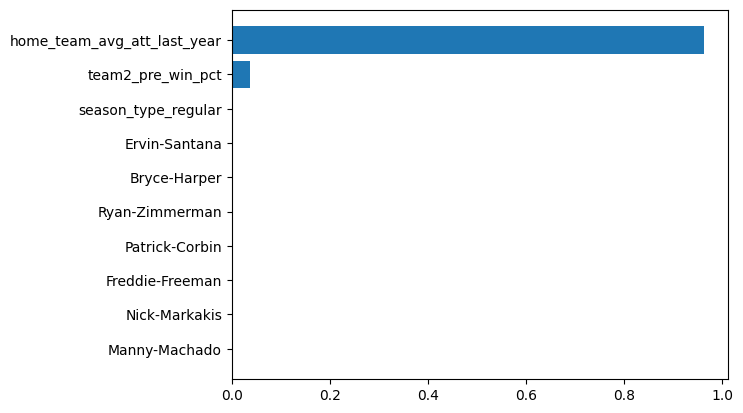

In [51]:
import matplotlib.pyplot as plt

feature_importances = regr.feature_importances_

num_features = 10

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
cols = data_train.columns
_ = ax.set_yticklabels(cols[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

In [52]:
print(feature_importances[indices][::-1][:20])

[0.        0.        0.        0.        0.        0.        0.
 0.        0.0374839 0.9625161]


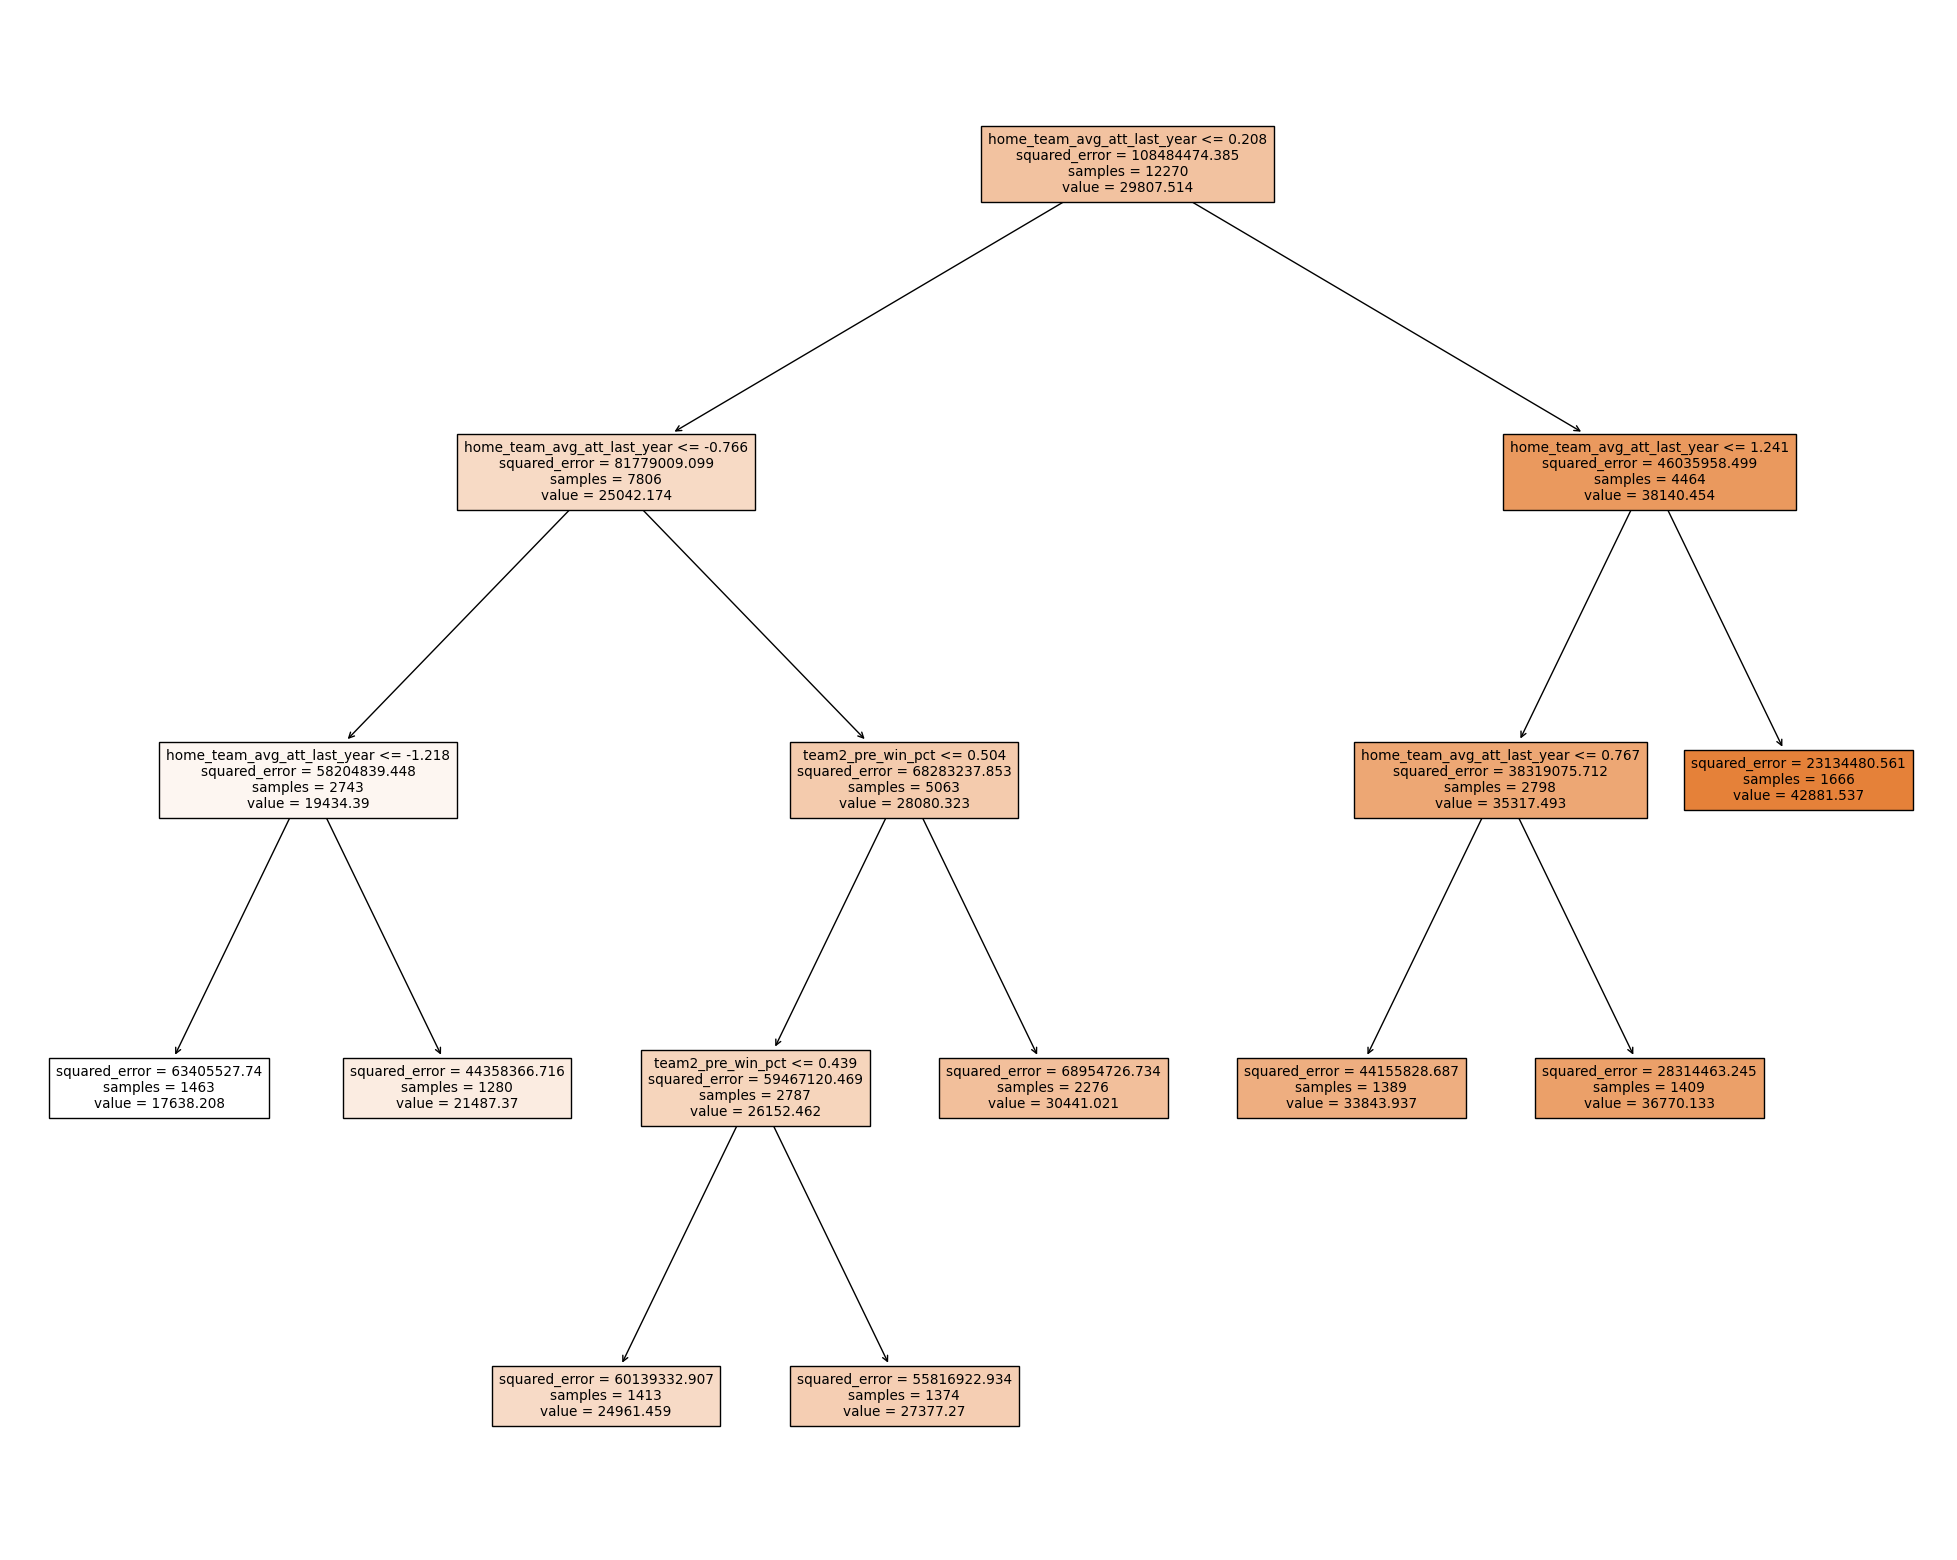

In [53]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr, feature_names=data_train.columns, filled=True)

### Evaluate testing set

In [54]:
y_pred = regr.predict(x_test)
evaluate(y_test, y_pred)

MSE: 68199851.14051495
RMSE: 8258.320116132272
MAE: 6695.693044561746
MAPE: 0.36960888330291464


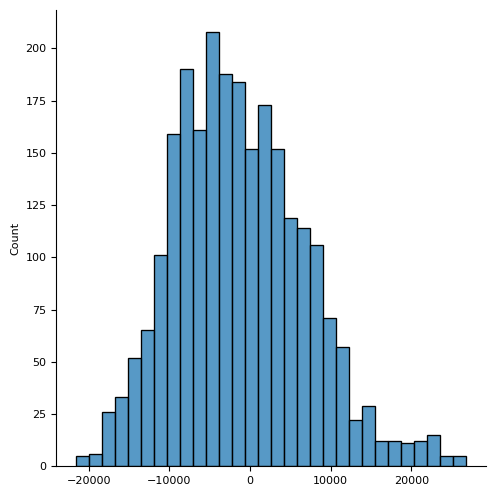

In [55]:
sns.displot(y_test - y_pred)

## Gradient Boosting

### Hyperparameters Tuning

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
#  'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.8, 1], 
parameters = {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.1, 0.05, 0.01, 0.001], 'max_depth': [3, 5, 8, 10]}
model = GradientBoostingRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01, 0.001],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [50, 100, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000,
                          random_state=42)
Best parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}


In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,13.606554,0.191306,0.010610,0.001626,0.1,3,50,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-3.078544e+07,-2.893812e+07,...,46.928383,36,-0.183319,-0.179659,-0.178351,-0.172160,-0.175639,-0.177826,0.003760,36
1,29.313213,0.564417,0.014013,0.000895,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-2.625904e+07,-2.479608e+07,...,28.654801,34,-0.162584,-0.160764,-0.157130,-0.152191,-0.154791,-0.157492,0.003799,34
2,154.222417,3.289582,0.033430,0.004275,0.1,3,500,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-2.100191e+07,-1.996701e+07,...,25.506248,25,-0.138945,-0.136887,-0.132546,-0.131230,-0.130548,-0.134031,0.003301,25
3,302.218182,5.941989,0.049845,0.005235,0.1,3,1000,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-1.967617e+07,-1.894500e+07,...,40.066417,21,-0.133221,-0.130161,-0.125356,-0.126329,-0.125377,-0.128089,0.003116,20
4,19.332552,0.345832,0.012611,0.002730,0.1,5,50,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-2.482522e+07,-2.238753e+07,...,56.911095,31,-0.159252,-0.152585,-0.151141,-0.147951,-0.150026,-0.152191,0.003841,30


### Train with best parameters

In [56]:
gb = GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=42)
gb = gb.fit(x_train, y_train)

In [57]:
train_predict = gb.predict(x_train)
evaluate(y_train, train_predict)

MSE: 762228.2541514663
RMSE: 873.0568447423491
MAE: 679.2441480149246
MAPE: 0.02707463145820087


Text(0.5, 0, 'Feature Importance')

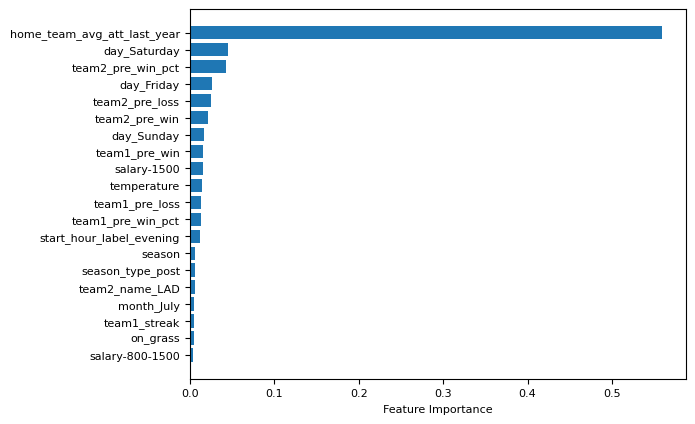

In [58]:
num_features = 20
sorted_idx = gb.feature_importances_.argsort()[::-1][:num_features]
cols = data_train.columns
plt.barh(cols[sorted_idx][:num_features][::-1], gb.feature_importances_[sorted_idx][:num_features][::-1])
plt.xlabel("Feature Importance")

In [59]:
gb.feature_importances_[sorted_idx][:10]

array([0.55946978, 0.04495901, 0.04243362, 0.02601271, 0.02465905,
       0.0218405 , 0.01685336, 0.01611918, 0.01562843, 0.01389883])

### Evaluate Testing set

In [60]:
y_pred = gb.predict(x_test)
evaluate(y_test, y_pred)

MSE: 42552493.17262165
RMSE: 6523.227205350251
MAE: 4995.590063274286
MAPE: 0.24607177151281776


## Adaboost

### Hyperparameters Tuning

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
parameters = {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.5, 0.1, 0.01, 0.001], 'loss': ['linear', 'square', 'exponential']}
model = AdaBoostRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.1, 0.01, 0.001],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: AdaBoostRegressor(learning_rate=0.1, loss='exponential', n_estimators=100,
                  random_state=42)
Best parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}


In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_n_estimators,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,22.508837,0.616215,0.451210,0.011833,0.5,linear,50,"{'learning_rate': 0.5, 'loss': 'linear', 'n_es...",-4.758108e+07,-4.796242e+07,...,16.268686,30,-0.259911,-0.261567,-0.253064,-0.259719,-0.257057,-0.258264,0.002975,30
1,45.257090,2.541378,0.887406,0.076824,0.5,linear,100,"{'learning_rate': 0.5, 'loss': 'linear', 'n_es...",-5.008462e+07,-5.125343e+07,...,74.276887,35,-0.269883,-0.272294,-0.265547,-0.269305,-0.263869,-0.268180,0.003053,35
2,48.311164,7.116659,0.909127,0.074438,0.5,linear,500,"{'learning_rate': 0.5, 'loss': 'linear', 'n_es...",-5.008462e+07,-5.212701e+07,...,98.771203,37,-0.269883,-0.275193,-0.265547,-0.271251,-0.263869,-0.269149,0.004058,37
3,48.659079,6.493892,0.878798,0.109103,0.5,linear,1000,"{'learning_rate': 0.5, 'loss': 'linear', 'n_es...",-5.008462e+07,-5.212701e+07,...,98.771203,37,-0.269883,-0.275193,-0.265547,-0.271251,-0.263869,-0.269149,0.004058,37
4,23.376624,0.401879,0.446806,0.015604,0.5,square,50,"{'learning_rate': 0.5, 'loss': 'square', 'n_es...",-4.970404e+07,-5.108639e+07,...,39.110355,36,-0.270903,-0.273686,-0.264634,-0.271637,-0.274150,-0.271002,0.003408,40


### Train with best parameters

In [61]:
ada = AdaBoostRegressor(learning_rate=0.1, loss='exponential', n_estimators=100, random_state=42)
ada = ada.fit(x_train, y_train)

In [62]:
train_predict = ada.predict(x_train)
evaluate(y_train, train_predict)

MSE: 44506525.602996446
RMSE: 6671.321128756766
MAE: 5300.475808905861
MAPE: 0.23929715887918396


Text(0.5, 0, 'AdaBoost Feature Importance')

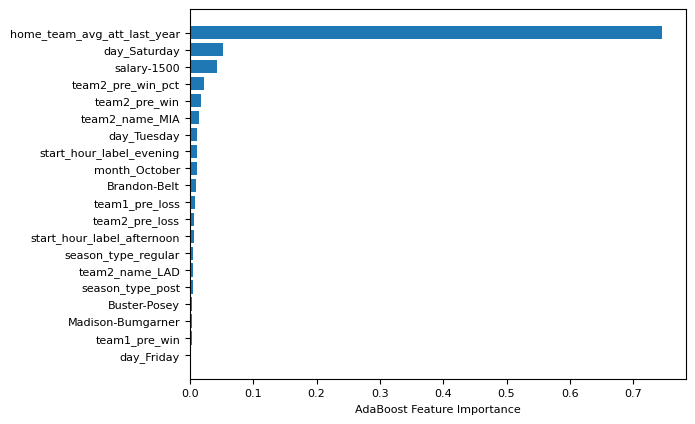

In [63]:
num_features = 20
sorted_idx = ada.feature_importances_.argsort()[::-1][:num_features]
cols = data_train.columns
plt.barh(cols[sorted_idx][:num_features][::-1], ada.feature_importances_[sorted_idx][:num_features][::-1])
plt.xlabel("AdaBoost Feature Importance")

In [64]:
ada.feature_importances_[sorted_idx][:10]

array([0.74578139, 0.05200922, 0.04356249, 0.02185984, 0.01718395,
       0.01410802, 0.0119959 , 0.01185436, 0.01059364, 0.00925483])

### Evaluate testing set

In [65]:
y_pred = ada.predict(x_test)
evaluate(y_test, y_pred)

MSE: 63357376.06581836
RMSE: 7959.734673079145
MAE: 6499.4485900505
MAPE: 0.3797414816757764


## Bagging

### Hyperparameters Tuning

In [ ]:
# skf = StratifiedKFold(n_splits=5)
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
n_estimators_grid = np.geomspace(5, 500, 5, endpoint=True, dtype=int) # 10 numbers between 5 and 500
n_estimators_dict = {}

for n_estimators in n_estimators_grid:
    regr = BaggingRegressor(n_estimators=n_estimators, random_state=42)
    results = cross_validate(regr, x_train, y_train, cv=5, scoring=scoring, return_train_score=True)

    metric_dict = {}
    metric_dict['MSE'] = results['test_neg_mean_squared_error'].mean()
    metric_dict['RMSE (Train)'] = results['train_neg_root_mean_squared_error'].mean()
    metric_dict['RMSE'] = results['test_neg_root_mean_squared_error'].mean()
    metric_dict['MAE'] = results['test_neg_mean_absolute_error'].mean()
    metric_dict['MAPE'] = results['test_neg_mean_absolute_percentage_error'].mean()
    metric_dict['fit_time'] = results['fit_time'].mean()
    metric_dict['score_time'] = results['score_time'].mean()

    n_estimators_dict[n_estimators] = metric_dict

In [ ]:
metric_df = pd.DataFrame(n_estimators_dict).T.reset_index().rename(columns={'index': 'n_estimators'})
metric_df

,n_estimators,MSE,RMSE (Train),RMSE,MAE,MAPE,fit_time,score_time
0,5,-3.508660e+07,-2248.654698,-5916.830610,-4444.372029,-0.185523,2.269422,0.051084
1,15,-3.174788e+07,-1850.854663,-5625.651302,-4229.927069,-0.176812,5.147037,0.078979
2,49,-3.065770e+07,-1678.355158,-5527.407774,-4146.482850,-0.173714,14.546918,0.236697
3,158,-3.027782e+07,-1626.239790,-5493.790275,-4120.761142,-0.172471,48.639971,0.767320
4,500,-3.013973e+07,-1611.524880,-5481.823852,-4107.168275,-0.171615,146.573884,2.517257


In [ ]:
best_grid = metric_df[abs(metric_df['RMSE']) == abs(metric_df['RMSE']).min()]
best_rmse = best_grid['RMSE'].values[0]
best_nest = best_grid['n_estimators'].values[0]

print(f'Best number of trees = {best_nest} with RMSE = {best_rmse}')

Best number of trees = 500 with RMSE = -5481.823852206085


### Train with best parameters

In [67]:
# regr = BaggingRegressor(n_estimators=1000, random_state=0).fit(scaled_X, y) # too big
best_nest = 49
regr = BaggingRegressor(n_estimators=best_nest, random_state=0).fit(x_train, y_train) # fit time 爆炸成長前

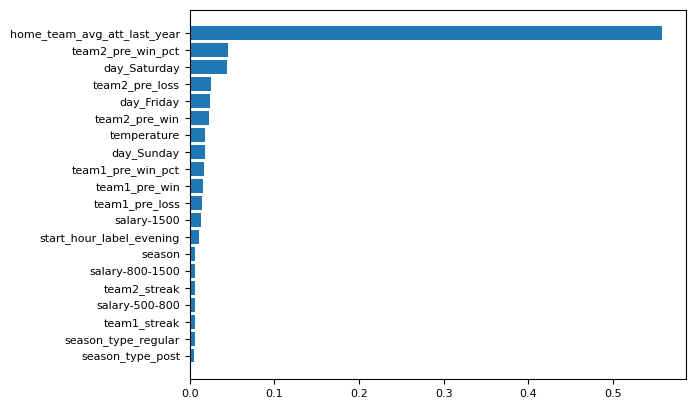

In [68]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(data_train.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

In [69]:
print(feature_importances[indices][::-1][:20])

[0.00502742 0.0055707  0.00566855 0.00613975 0.00615762 0.00637022
 0.00646034 0.01056963 0.01364827 0.01418122 0.01602844 0.01678737
 0.01734981 0.01764123 0.02232388 0.02333487 0.02455445 0.04405735
 0.04513598 0.55820928]


### Evaluate testing set

In [70]:
y_pred = regr.predict(x_test)
evaluate(y_test, y_pred)

MSE: 44819289.70259665
RMSE: 6694.7210324700345
MAE: 5153.995809857686
MAPE: 0.26068584981706205


## SVM (SVR)
### Hyperparameters Tuning

In [ ]:
def find_best_index(eval_results: dict[str, np.array]) -> int:
    # returns a n-scorers x n-parameter-set dimensional array
    means_of_splits = np.array(
        [values for name, values in eval_results.items() if name.startswith('mean_test')]
    )
    # this is a n-parameter-set dimensional vector
    mean_of_all_scores = np.mean(means_of_splits, axis=0) 
    # get index of maximum value which corresponds to the best parameter set
    return np.argmax(mean_of_all_scores) 

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
param_grid = {'C': [10, 100], 'gamma': [1, 10]}

grid = GridSearchCV(SVR(kernel='linear'),param_grid, refit=find_best_index, verbose=2, scoring=scoring, cv=5, n_jobs=-1)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=SVR(kernel='linear'), n_jobs=-1,
             param_grid={'C': [10, 100], 'gamma': [1, 10]},
             refit=<function find_best_index at 0x000002A23F1856C0>,
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'],
             verbose=2)

In [ ]:
grid.best_estimator_

SVR(C=100, gamma=1, kernel='linear')

### Use the best hyperparameters to train the model

In [71]:
regr = SVR(C=100, gamma=1, kernel='linear').fit(x_train, y_train)

In [72]:
train_predict = regr.predict(x_train)
evaluate(y_train, train_predict)

MSE: 28155823.260461494
RMSE: 5306.206107989163
MAE: 3989.6921239900475
MAPE: 0.1563886986485198


In [73]:
def f_importances(coef, names, size=10):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names), reverse=True))

    if size > len(names):
        size = len(names)
    plt.barh(range(size), imp[:size][::-1], align='center')
    plt.yticks(range(size), names[:size][::-1])
    plt.show()

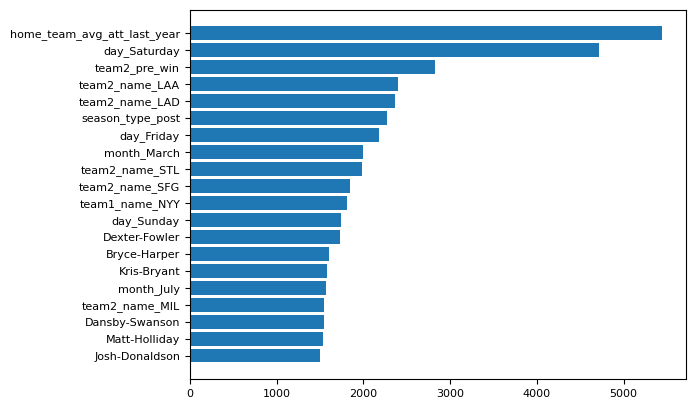

In [75]:
# matplotlib
import matplotlib.pyplot as plt

f_importances(regr.coef_[0], list(data_train.columns), size=20)

### Evaluate testing set

In [76]:
y_pred = regr.predict(x_test)
evaluate(y_test, y_pred)

MSE: 42669368.60599447
RMSE: 6532.179468293448
MAE: 4993.156540745768
MAPE: 0.22860754671528793


## XGBoost

### Hyperparameters Tuning

In [ ]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
parameters = {'n_estimators': [100, 300, 500, 1000], 'max_depth':[3, 5, 8, 10], 'learning_rate': [0.1, 0.05, 0.01, 0.001], 'colsample_bytree': [0.3, 0.7, 1]}
model = XGBRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.7, 1],
                         'learning_rate': [0.1, 0.05, 0.01, 0.001],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [100, 300, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}


In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,2.995321,0.030717,0.039835,0.000750,0.3,0.1,3,100,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.594823e+07,...,31.945466,118,-0.162909,-0.171270,-0.163074,-0.156932,-0.161269,-0.163091,0.004652,118
1,8.593403,0.232977,0.048244,0.001471,0.3,0.1,3,300,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.159451e+07,...,34.082385,96,-0.143330,-0.150442,-0.139939,-0.138256,-0.140630,-0.142519,0.004285,98
2,14.348027,0.425265,0.056653,0.001962,0.3,0.1,3,500,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.014178e+07,...,32.623213,86,-0.137309,-0.143659,-0.133450,-0.132431,-0.134507,-0.136271,0.004037,84
3,27.592251,0.448472,0.083475,0.005857,0.3,0.1,3,1000,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-1.876574e+07,...,40.535823,70,-0.130844,-0.135564,-0.125880,-0.126039,-0.128659,-0.129397,0.003586,68
4,4.193808,0.048735,0.044841,0.000981,0.3,0.1,5,100,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.137225e+07,...,15.531931,94,-0.143541,-0.149107,-0.143233,-0.138894,-0.141714,-0.143298,0.003338,99


### Train with best parameters

In [77]:
xgb = XGBRegressor(colsample_bytree=0.3, learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=42)
xgb = xgb.fit(x_train, y_train)

In [78]:
train_predict = xgb.predict(x_train)
evaluate(y_train, train_predict)

MSE: 1333964.366610259
RMSE: 1154.973751481071
MAE: 848.176519840057
MAPE: 0.033736134759445036


Text(0.5, 0, 'Xgboost Feature Importance')

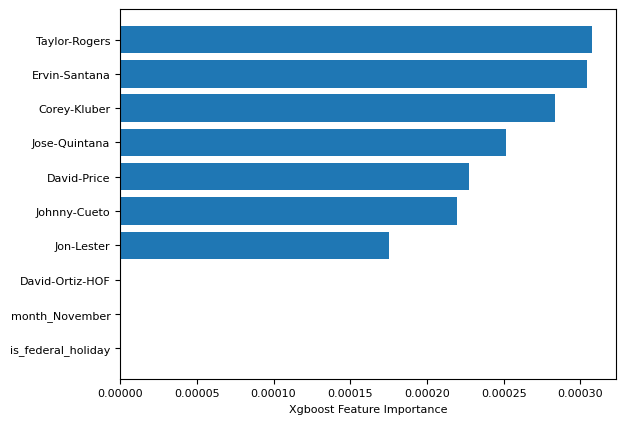

In [79]:
from matplotlib import pyplot as plt
sorted_idx = xgb.feature_importances_.argsort()[::-1]
cols = data_train.columns
plt.barh(cols[sorted_idx][::-1][:10], xgb.feature_importances_[sorted_idx][::-1][:10])
plt.xlabel("Xgboost Feature Importance")

In [80]:
xgb.feature_importances_[sorted_idx][:10]

array([0.18693662, 0.04528832, 0.03469901, 0.03455453, 0.02956478,
       0.02850856, 0.02736727, 0.02551978, 0.02524949, 0.0245065 ],
      dtype=float32)

### Evaluate Testing set

In [81]:
y_pred = xgb.predict(x_test)
evaluate(y_test, y_pred)

MSE: 35477295.46283122
RMSE: 5956.282016730842
MAE: 4624.168159069849
MAPE: 0.23540849276604314


## All Model Results
```
==================== Average Attendance Only ====================
MSE:  88887032.10373585
RMSE:  9427.991944403424
MAE:  7635.267692974473
MAPE 0.48553017390069386
```


```
==================== MA(5~10) ====================
Test MSE: 72263690.8802977
Test RMSE: 8500.805307751596
Test MAE: 6766.844407456573
Test MAPE: 0.34921441042822426
```

```
KNN
MSE: 61096566.40299257
RMSE: 7816.429261689289
MAE: 6090.924326831434
MAPE: 0.28480501695029914
```
```
Lasso
MSE: 40184495.392723225
RMSE: 6339.12418183484
MAE: 4907.753057265744
MAPE: 0.22707434693591624
```

```
Ridge
MSE: 41192972.82512903
RMSE: 6418.175194331254
MAE: 4965.694192375581
MAPE: 0.22843541868557435
```

```
Decision Tree
MSE: 68199851.14051495
RMSE: 8258.320116132272
MAE: 6695.693044561746
MAPE: 0.36960888330291464
```

```
Gradient Boosting
MSE: 42552493.17262165
RMSE: 6523.227205350251
MAE: 4995.590063274286
MAPE: 0.24607177151281776
```

````
adaboost
MSE: 63357376.06581836
RMSE: 7959.734673079145
MAE: 6499.4485900505
MAPE: 0.3797414816757764
````


```
========== Bagging Regressor ==========
MSE: 44819289.70259665
RMSE: 6694.7210324700345
MAE: 5153.995809857686
MAPE: 0.26068584981706205
```


```
========== SVM ==========
MSE: 42669368.60599447
RMSE: 6532.179468293448
MAE: 4993.156540745768
MAPE: 0.22860754671528793
```

```
========== XGBoost ==========
MSE: 35477295.46283122
RMSE: 5956.282016730842
MAE: 4624.168159069849
MAPE: 0.23540849276604314
```

Note:
+ 多數模型中 `home team avg att last year` 是很重要的一個重要欄位，而也有許多模型把特定的隊伍當作重要的參數之一。
+ 所有統計模型的結果都比拿前 5 ~ 10 場的平均要來得好，也比只能去年各場地平均人數的結果要好。
+ 在所有統計模型中，XGboost 是唯一 RMSE 低於 6000 的模型。
+ KNN, Adaboost, Decision Tree 是當中比較不好的模型，因此下一輪我們將會捨棄這些模型。
+ 因為發現 `home team avg att last year` 這種過往紀錄容易是個重要考量因素，因此我們下一輪將會將入該場地前 5~10 場的平均觀眾進場人數加入模型訓練的欄位中。 